<a href="https://colab.research.google.com/github/jhermosillo/diplomado_CDD2019/blob/master/05%20Redes%20Neuronales/Notebooks/Propagacion_directa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:50px;" align="left"> <img align="left" width="30%" src="../img/cerebro_1.jpg"/>    
    Redes Neuronales Artificiales - Propagación directa

___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import optimize
from scipy.io import loadmat

## Para subir carpetas a Colab

In [2]:
# !apt-get install subversion
# !svn checkout "https://github.com/jhermosillo/diplomado_CDD2019/trunk/05%20Redes%20Neuronales/Data/"

## Clasificación multiclase

Para este ejercicio, usaremos una red neuronal para reconocer los dígitos escritos a mano (de 0 a 9). 

### Conjunto de datos

* Se proporciona un conjunto de datos en `datosMNIST.mat` que contiene 5000 ejemplos de entrenamiento de dígitos escritos a mano (este es un subconjunto del conjunto de datos de dígitos escritos a mano [MNIST] (http://yann.lecun.com/exdb/mnist). El formato `.mat` significa que los datos se han guardado en un formato de matriz Octave / MATLAB nativo, en lugar de un formato de texto (ASCII) como un archivo csv. 

* Python proporciona mecanismos para cargar el formato nativo de MATLAB usando la función `loadmat` dentro del módulo` scipy.io`. Esta función devuelve un diccionario de Python con claves que contienen los nombres de las variables dentro del archivo `.mat`.

* Hay 5000 ejemplos de entrenamiento en `datosMNIST.mat`, donde cada ejemplo de entrenamiento es una imagen del dígito en escala de grises de $20\times 20$ píxeles. Cada píxel está representado por un número real que indica la intensidad de la escala de grises en esa ubicación. 

* La cuadrícula de pixeles de 20 por 20 se "desenrolla" en un vector de 400 dimensiones. Cada uno de estos ejemplos de capacitación se convierte en una sola fila en nuestra matriz de datos `X`. Esto nos da una matriz $X$ de 5000 por 400 donde cada fila es una instancia de entrenamiento para una imagen de dígitos escritos a mano.

$$ X = \begin{bmatrix} - \: (x ^ {(1)})^T \: - \\ - \: (x ^{(2)})^ T \: - \\ \vdots \\ - \: (x ^ {(m)})^ T \: - \end{bmatrix} $$

* La segunda parte del conjunto de entrenamiento es un vector 'y' de 5000 dimensiones que contiene etiquetas para el conjunto de entrenamiento.

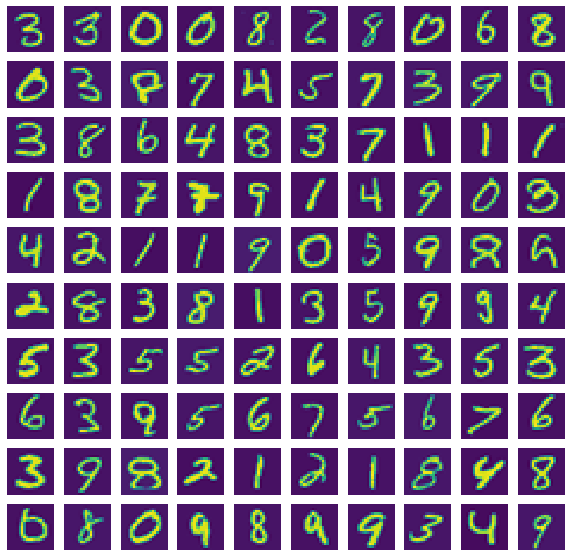

In [3]:
#  Datos de entrenamiento X, y
data = loadmat('../Data/datosMNIST')
X, y = data['X'], data['y'].ravel()

# Estos datos fueron creados en MATLAB donde no hay índice 0
y[y == 10] = 0

# tamaño del conjunto de instancias
m = y.size

# indices de una permutación aleatoria de instancias 
# para visualizarlas
indices = np.random.permutation(m)

# Elegimos 100 puntos al azar para desplegar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :].reshape((10,10,-1))

# visualización de los datos
fig, axarr = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(sel[i,j].reshape((20,20), order = 'F'))          
        axarr[i,j].axis('off')

3


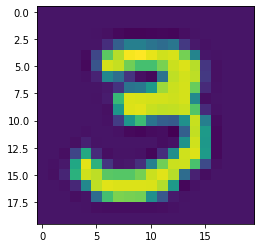

In [5]:
#1680
print(y[1680])
fig,ax=plt.subplots()
ax.imshow(X[1680].reshape((20,20),order='F'))

## Modelo de red neuronal

La red neuronal que vamos a implementar es la siguiente:

<img align="left" width="50%" src="../img/redneuronal.jpg"/> 

Tiene 3 capas: una capa de entrada, una capa oculta y una capa de salida. Recuerda que nuestras entradas son valores de pixeles de imágenes de dígitos. Dado que las imágenes tienen un tamaño de 20 × 20, esto nos da 400 neuronas de capa de entrada (excluyendo la neurona de polarización adicional que siempre genera +1). Como siempre, los datos de entrenamiento se cargarán en las variables $X$,$y$.

Se te ha proporcionado un conjunto de parámetros de la red ($\Theta^{(1)}$, $\Theta^{(2)}$) ya entrenados. Estos están almacenados en `pesosFW.mat`. La siguiente celda carga esos parámetros en `Theta1` y` Theta2`. Los parámetros tienen dimensiones para una red neuronal con 25 neuronas en la segunda capa y 10 neuronas de salida (correspondientes a las clases de 10 dígitos).

### Parámetros para el ejercicio

In [6]:
# Parámetros
neuronas_de_entrada  = 400  # Imágenes de entrada 20x20
neuronas_ocultas = 25   # 25 neuronas coultas
etiquetas = 10          # 10 etiquetas, clases de 0 a 9

# Carga el archivo .mat que regresa un diccionario 
pesos = loadmat('../Data/pesosFW.mat')

# obtén los pesos del modelo del diccionario
# Theta1 es una matriz de 25 x 401
# Theta2 es una matriz de 10 x 26
Theta1, Theta2 = pesos['Theta1'], pesos['Theta2']

# intercambia la primera y última fila de Theta2, 
# debido a que los datos se originarion en MATLAB, con la indexación de MATLAB. 
Theta2 = np.roll(Theta2, 1, axis=0)

In [7]:
print(Theta1.shape)
print(Theta2.shape)
print(X.shape)

(25, 401)
(10, 26)
(5000, 400)


## Propagación directa y predicción

* Completa el código en la función predicción para devolver la predicción de la red neuronal. 
* Debes implementar el cálculo directo de $h_{\theta}(x^(i))$ para cada ejemplo $i$ y devolver las predicciones asociadas. 
* De acuerdo con la estrategia de clasificación de uno contra todos, la predicción de la red neuronal será la etiqueta que tenga el mayor valor $(h_{\theta}(x^(i)))_k$

### Función de activación sigmoide

In [8]:
def sigmoide(z):
    return 1.0 / (1.0 + np.exp(-z))

### &#9998; Implementa la función `predict`

<div class="alert alert-box alert-warning">
** Nota de implementación: ** La matriz $X$ contiene las instancias en cada fila. Cuando completes el código en la función $predict$, deberás agregar la columna de 1's a la matriz. Las matrices $Theta1$ y $Theta2$ contienen los parámetros para cada neurona en sus filas. Específicamente, la primera fila de $Theta1$ corresponde a los datos que van a ser procesados por la primera neurona oculta en la segunda capa. En $numpy$, cuando se calcula $z^{(2)}=\Theta^{(1)}a^{(1)}$, hay que asegurarse de indexar (y si es necesario, transponer) $X$ correctamente para obtener $a^{(l)}$ como un vector 1-D.
</div>
<a id="predict"></a>

In [9]:
def predict(Theta1, Theta2, X):
    """
    Predice la etiqueta de una entrada dada una red entrenada.
    
    Entradas:
    ----------
    Theta1 : tipo arreglo 
        Pesos para la capa 1 de la red neuronal.
        Tiene shape (2da capa x capa de entrada)
    
    Theta2: tipo arreglo
        Pesos para la capa 2 de la red neuronal.
        Tiene shape (capa de salida x 2da capa)
    
    X : tipo arreglo (matriz)
        Las imágenes de entrada de tamaño (instancias x dimensiones de laa imagen).
    
    Salidas: 
    ------
    p : tipo arreglo
        Vector de predicciones con etiquetas predichas para cada ejemplo
        Su tamaño es igual al número de instancias.
    
    """
    # Necesitamos a X 2D
    print(X.shape)
    if X.ndim == 1:
        X = X[None]
    
    # numero de instancias y etiquetas
    m = X.shape[0]
    etiquetas = Theta2.shape[0]

    # Debes regresar el valor de estas variables correctamente 
    p = np.zeros(X.shape[0])

    """ ====================== TU CODIGO AQUI ======================
    TIP
    ----
    Este código se puede hacer todo vectorizado usando la función numpy argmax.
    En particular, la función argmax devuelve el índice del elemento max.
    Si tus instancias están en filas, entonces, puede usar np.argmax (A, axis = 1) 
    para obtener el índice del máximo para cada fila. Este índice correspondería al valor 
    de la clase a la que pertenece la instancia correspondiente.
    """
    shapes=[]
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    shapes.append(a1.shape)
    a2 = sigmoide(a1 @ Theta1.T)
    shapes.append(a2.shape)
    a2 = np.hstack((ones, a2))
    shapes.append(a2.shape)
    p = sigmoide(a2 @ Theta2.T)
    shapes.append(p.shape)
    p=np.argmax(p, axis = 1)
    print(shapes)
    """ ============================================================="""
    return p

### Prueba el modelo

* Deberías ver una exactitud de aproximadamente 97.5%.

In [10]:
pred = predict(Theta1, Theta2, X)
np.mean(pred == y) * 100

(5000, 400)
[(5000, 401), (5000, 25), (5000, 26), (5000, 10)]


97.52

### Para visualizar una por una las instancias de entrada y la predicción correspondiente

(400,)
[(1, 401), (1, 25), (1, 26), (1, 10)]
Predición de la Red Neuronal: 5


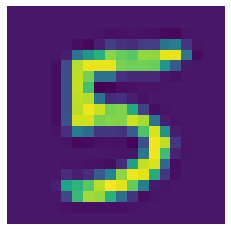

In [11]:
fig,ax=plt.subplots(figsize=(4,4))
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    ax.imshow(X[i,:].reshape((20,20), order = 'F'))          
    ax.axis('off')    
    pred = predict(Theta1, Theta2, X[i, :])
    print('Predición de la Red Neuronal: {}'.format(*pred))
else:
    print('No hay más imágenes.')